## Distance matrix based on the centroids

1. Firts we calculate the distance matriz between the people
2. We obtain the mean of the distance of each parcel of the producer (one producer could have more than one parcel)
3. To obtain only one value per producer we make a PCA

In [1]:
import geopandas as gpd # Update
import folium

# Cargar el shapefile
shapefile_path = '../DataIn/Centroides/Centroides_Nome_atu.shp'  
gdf = gpd.read_file(shapefile_path)

In [2]:
# Crear un mapa con Folium
mapa = folium.Map(location=[gdf.geometry.y.mean(), gdf.geometry.x.mean()], zoom_start=13)

# Añadir las parcelas al mapa
for _, row in gdf.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=row['0_Nome_atu']
    ).add_to(mapa)

mapa

In [ ]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic

# Load the Excel file
file_path = '../DataIn/Centroides.xlsx'  
xls = pd.ExcelFile(file_path)

# Load the `matriz_de_distancia` sheet into a DataFrame
df = pd.read_excel(xls, sheet_name='centroides_nome_atu')

# Assume the DataFrame contains the columns '0_Nome_atu', 'X', 'Y'
productores = df['0_Nome_atu'].unique()

# Create a list to store the average distances between parcels for each producer
dist_avg_per_productor = []

# Calculate the average distance between parcels for each producer
for productor in productores:
    parcelas = df[df['0_Nome_atu'] == productor]
    coords = parcelas[['X', 'Y']].values
    dist_matrix = np.zeros((len(coords), len(coords)))
    
    for i in range(len(coords)):
        for j in range(len(coords)):
            if i != j:
                dist_matrix[i, j] = geodesic(coords[i], coords[j]).meters
                
    # Calculate the average distance
    avg_distance = np.mean(dist_matrix[np.triu_indices(len(coords), k=1)])
    dist_avg_per_productor.append((productor, avg_distance))



In [ ]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic

# Load the Excel file
file_path = '../DataIn/Centroides.xlsx'  
xls = pd.ExcelFile(file_path)

# Load the `centroides_nome_atu` sheet into a DataFrame
df = pd.read_excel(xls, sheet_name='centroides_nome_atu')

# Assume the DataFrame contains the columns '0_Nome_atu', 'X', 'Y'
productores = df['0_Nome_atu'].unique()

# Create a list to store the average distances between parcels for each producer
dist_avg_per_productor = []

# Calculate the average distance between parcels for each producer
for productor in productores:
    parcelas = df[df['0_Nome_atu'] == productor]
    coords = parcelas[['X', 'Y']].values
    dist_matrix = np.zeros((len(coords), len(coords)))
    
    for i in range(len(coords)):
        for j in range(len(coords)):
            if i != j:
                dist_matrix[i, j] = geodesic(coords[i], coords[j]).meters
                
    # Calculate the average distance
    avg_distance = np.mean(dist_matrix[np.triu_indices(len(coords), k=1)])
    dist_avg_per_productor.append((productor, avg_distance))

# Convert the list into a DataFrame
dist_avg_df = pd.DataFrame(dist_avg_per_productor, columns=['producer', 'avg_dist_within'])

# Create a matrix of average distances between producers
dist_matrix_between_productores = np.zeros((len(productores), len(productores)))

for i in range(len(productores)):
    for j in range(len(productores)):
        if i != j:
            coords_i = df[df['0_Nome_atu'] == productores[i]][['X', 'Y']].values
            coords_j = df[df['0_Nome_atu'] == productores[j]][['X', 'Y']].values
            dists = []
            for coord_i in coords_i:
                for coord_j in coords_j:
                    dists.append(geodesic(coord_i, coord_j).meters)
            dist_matrix_between_productores[i, j] = np.mean(dists)

# Create a DataFrame with the producer names and the matrix of distances between producers
dist_matrix_between_productores_df = pd.DataFrame(dist_matrix_between_productores, index=productores, columns=productores)




c:\Users\jesus\anaconda3\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


La matriz de distancias y las distancias promedio se han guardado en 'Matriz_distancia_calculada.xlsx'


In [ ]:
# Save the matrix of distances and average distances in an Excel file
output_path = '../DataIntermediate/Matriz_distancia_calculada.xlsx'
with pd.ExcelWriter(output_path) as writer:
    dist_matrix_between_productores_df.to_excel(writer, sheet_name='Matriz_de_Distancias_Entre_Productores')
    dist_avg_df.to_excel(writer, sheet_name='Distancias_Promedio_Dentro', index=False)

print("La matriz de distancias y las distancias promedio se han guardado en 'Matriz_distancia_calculada.xlsx'")

In [18]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
# Perform PCA on the matrix of distances
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dist_matrix_between_productores_df)
# Create a DataFrame with the PCA results.
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=productores)

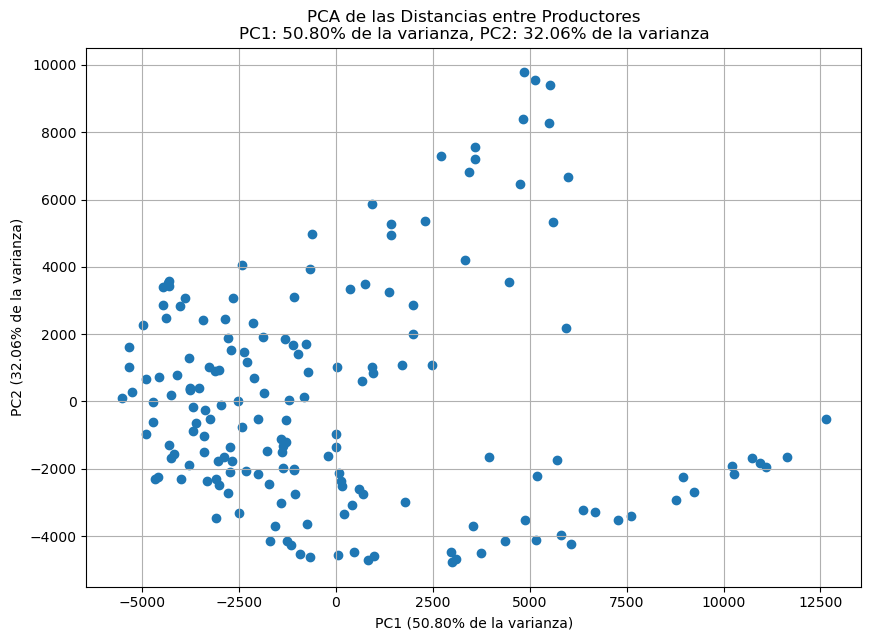

In [ ]:
# Perform PCA on the distance matrix
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dist_matrix_between_productores_df)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=dist_matrix_between_productores_df.index)

# Calculate the percentage of variance explained by each principal component
explained_variance = pca.explained_variance_ratio_

# Save the distance matrix, average distances, and PCA results to an Excel file
output_path = '../DataIntermediate/Matriz_distancia_calculada_con_PCA.xlsx'
with pd.ExcelWriter(output_path) as writer:
    pca_df.to_excel(writer, sheet_name='PCA_Result')

# Plot the PCA results without labels
plt.figure(figsize=(10, 7))
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.title(f'PCA of Distances between Producers\nPC1: {explained_variance[0]*100:.2f}% variance, PC2: {explained_variance[1]*100:.2f}% variance')
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}% variance)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}% variance)')
plt.grid(True)
plt.show()


 
*Interpretation of the Graph:*.
The graph shows a spread of points in the space of the first two principal components (PC1 and PC2).
Most of the variability in the data is captured on the PC1 axis.
Producers that are close to each other in this space have similar distances between their plots.
Producers farther apart on the graph have more diverse distances between their plots.
*Clusters and Outliers.
There may be groups of producers with similar distances if a clustering of points is observed in certain areas of the graph.
Points that are far from the center or main clusters can be considered outliers. These represent producers whose distances are significantly different from the others.

In [ ]:
import pandas as pd
from geopy.distance import geodesic
import numpy as np

# Load data for producers' houses
casas_df = pd.read_excel('../DataIn/VarExpl/Puntos_moranza.xlsx') 

# Load data for parcels
parcels_df = pd.read_excel('../DataIn/Centroides.xlsx', sheet_name='Hoja1')  
parcels_df = parcels_df[['0_Nome_atu', 'X', 'Y']]  # Adjust columns according to your data

# Rename columns for consistency
casas_df.columns = ['Name', 'X_house', 'Y_house']
parcels_df.columns = ['Name', 'X_parcel', 'Y_parcel']

# Create a list to store average distances
dist_avg_list = []

# Calculate the average distance from the house to the parcels for each producer
for nombre in casas_df['Nombre'].unique():
    casa = casas_df[casas_df['Nombre'] == nombre].iloc[0]
    parcelas = parcels_df[parcels_df['Nombre'] == nombre]
    
    if not parcelas.empty:
        dists = []
        casa_coords = (casa['Y_casa'], casa['X_casa'])
        
        for _, parcela in parcelas.iterrows():
            parcela_coords = (parcela['Y_parcela'], parcela['X_parcela'])
            dists.append(geodesic(casa_coords, parcela_coords).meters)
        
        avg_dist = np.mean(dists)
        dist_avg_list.append((nombre, avg_dist))

# Convertir la lista a un DataFrame
dist_avg_df = pd.DataFrame(dist_avg_list, columns=['Nombre', 'Avg_Distancia'])

# Guardar el resultado en un archivo Excel
output_path = '../DataIntermediate/Distancias_promedio_casas_parcelas.xlsx'
dist_avg_df.to_excel(output_path, index=False)

print(f"El archivo con las distancias promedio se ha guardado como '{output_path}'")


El archivo con las distancias promedio se ha guardado como '../DataIntermediate/Distancias_promedio_casas_parcelas.xlsx'
